In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')



# 데이터 불러오기
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## 데이터 전처리
def preprocess_data(df):
  
    # 결측치 처리
    def age():
        
        train_test_data = [train, test] # combining train and test dataset

        for dataset in train_test_data: 
            dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
            
        title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, 
            "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, "Major": 3, "Mlle": 3,"Countess": 3,
            "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, "Dona" : 3, "Mme": 3,"Capt": 3,"Sir": 3 }
        
        for dataset in train_test_data:
            dataset['Title'] = dataset['Title'].map(title_mapping)
        
        train["Age"] = train.groupby("Title")["Age"].transform(lambda x: x.fillna(x.median()))
        test["Age"] = test.groupby("Title")["Age"].transform(lambda x: x.fillna(x.median()))
    age()
    
    def Cabin():
        train_test_data = [train, test]
        
        for dataset in train_test_data:
            dataset['Cabin'] = dataset['Cabin'].fillna('').astype(str).str[:1]
        

        cabin_mapping = {"A": 0, "B": 0.4, "C": 0.8, "D": 1.2, "E": 1.6, "F": 2, "G": 2.4, "T": 2.8}
        for dataset in train_test_data:
            dataset['Cabin'] = dataset['Cabin'].map(cabin_mapping)

        train["Cabin"] = train.groupby("Pclass")["Cabin"].transform(lambda x: x.fillna(x.median()))
        test["Cabin"] = train.groupby("Pclass")["Cabin"].transform(lambda x: x.fillna(x.median()))
    Cabin()
    
    
    # df['Fare'] = df['Fare'].fillna(df['Fare'].mean())
    # df['Age'] = df['Age'].fillna(df['Age'].mean())
    # df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])     #최빈값으로 설정 = > s
    
    # Embarked 열에서 최빈값이 있는지 확인하고 결측치를 채움
    embarked_mode = df['Embarked'].mode()
    if not embarked_mode.empty:
        df['Embarked'] = df['Embarked'].fillna(embarked_mode[0])
    
    # 범주형 변수 처리
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
    
    # 필요한 특성 선택
    # features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
    features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked'] # Cabin 추가 
    features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Cabin', 'Embarked'] # Cabin 추가  ,fare삭제
    return df[features]

X = preprocess_data(train)
y = train['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 생성 및 학습
import tensorflow as tf
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2



from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# 데이터 정규화
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Sequential 모델 정의
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1, activation='sigmoid')
])

# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# 모델 학습
from tensorflow.keras.callbacks import EarlyStopping

model.optimizer.learning_rate = 0.0005
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


model_hist = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100, batch_size=32,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/100


c:\Users\kjins\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5153 - loss: 2.2834 - val_accuracy: 0.7374 - val_loss: 2.0073 - learning_rate: 5.0000e-04
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7314 - loss: 1.9371 - val_accuracy: 0.7542 - val_loss: 1.9353 - learning_rate: 5.0000e-04
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7186 - loss: 1.8686 - val_accuracy: 0.7207 - val_loss: 1.8757 - learning_rate: 5.0000e-04
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7793 - loss: 1.7588 - val_accuracy: 0.7374 - val_loss: 1.8220 - learning_rate: 5.0000e-04
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7719 - loss: 1.6827 - val_accuracy: 0.7654 - val_loss: 1.7698 - learning_rate: 5.0000e-04
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7567 - loss: 1.7273 - val_accuracy: 0.7821 - val_loss: 1.7214 - learning_rate: 5.0000e-04
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7838 - loss: 1.63

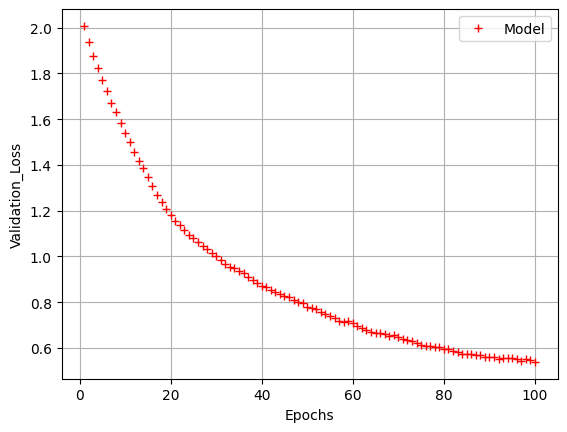

In [51]:
import matplotlib.pyplot as plt


epochs = range(1, len(model_hist.history['val_loss']) + 1)
model_val_loss = model_hist.history['val_loss']

plt.plot(epochs, model_val_loss, 'r+', label='Model')
plt.xlabel('Epochs')
plt.ylabel('Validation_Loss')
plt.legend()
plt.grid()
plt.show()

In [52]:
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy:.2f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8284 - loss: 0.5321
Validation Accuracy: 0.82


In [53]:
# 테스트 데이터 전처리
X_test = preprocess_data(test)

# 테스트 데이터 정규화 (train에서 학습한 scaler를 사용하여 동일한 방식으로 정규화)
X_test_scaled = scaler.transform(X_test)

# 테스트 데이터 예측
test_pred = model.predict(X_test_scaled)

# 예측 결과를 0 또는 1로 변환
test_pred = (test_pred > 0.5).astype(int).flatten()



14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\kjins\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\kjins\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\kjins\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\kjins\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\kjins\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keep

In [47]:
# y_test를 랜덤하게 생성 (0 또는 1)
np.random.seed(42)  # 재현성을 위해 시드 고정
y_test = np.random.randint(0, 2, size=X_test.shape[0])

# 테스트 데이터 평가
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4900 - loss: 0.8849
Test Loss: 0.8828
Test Accuracy: 0.4928


In [54]:
# 제출 파일 생성
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': test_pred
})
submission.to_csv('submission(git2).csv', index=False)
print('제출 파일이 생성되었습니다.')

제출 파일이 생성되었습니다.
